In [2]:
from scipy.integrate import odeint
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import lombscargle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
import itertools
from numpy import *
import seaborn as sns
from sklearn.metrics import accuracy_score
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import os
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.metrics import precision_score 
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
#import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import warnings

In [3]:
# If run locally true then use the path Curvassinteticas if not run from Manu path.
run_locally = True
dff = []
if run_locally:
    dir = 'obs/AGNs/'
    path = 'obs/AGNs/'
    for i in range(1, 26):
        filename = f"Curvassinteticas/orig{'0' if i < 10 else ''}{i}.dat"
        dff.append(np.loadtxt(filename))
else:
    dir = '/home/anakin/Documents/Tesis/Codigo/AGNs/'
    path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
    for i in range(1, 26):
        filename = f"/home/anakin/Documents/Tesis/Codigo/Curvassinteticas/orig{'0' if i < 10 else ''}{i}.dat"
        dff.append(np.loadtxt(filename))

In [4]:
#Function to read the files and separate each AGN and its errors.

def agns(data):
    
    #Read the first column which is the Julian days.
    t = data[:,0]
    
    agn=[] #AGNs
    err_agn=[] #AGNs errors
    star=[] #Calibration Stars
    err_star=[] #Calibration Stars errors
    agn_p=[] #Periodic AGNs
    err_agn_p=[] #Periodic AGNs errors

    for i in range(1, 544, 2):

        if i <  400: 
 
            agns = data[:,i]
            err_agns = data[:,i+1]
            agn.append(agns)
            err_agn.append(err_agns)
            
        elif i > 400 and i < 526:
   
            stars = data[:,i]
            err_stars = data[:,i+1]
            star.append(stars)
            err_star.append(err_stars)
            
        elif i > 526: 

            agn_ps = data[:,i]
            err_agn_ps = data[:,i+1]
            agn_p.append(agn_ps)
            err_agn_p.append(err_agn_ps)
            
    return agn, err_agn, star, err_star, agn_p, err_agn_p, t
                                       
    

In [5]:
#We calibrate the observed fluxes of the AGNs using the calibration stars.

#For this, we choose for each AGN the star that has the magnitude most similar to that of the AGN.


#We use the mean of each star and AGN for comparison. 


#We define a function that calculates the star with mean magnitude most similar to the AGN and then subtracts those magnitudes and this is what we will use to determine

#whether an AGN is variable or not.

def calibration(agn, star, err_agn, err_star):

    rest = []
    
    for i in range(63):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude

        err_cal = err_agn + err_star[ind_min]#Error calibrated magnitude 
        
    return cal, err_cal

In [6]:
def extract_features(mag, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
        'mag_w_e_mean': np.mean(mag_w_err),
        'mag_w_e_var': np.var(mag_w_err),
        'mag_w_e_skew': skew(mag_w_err),
        'mag_w_e_kurt': kurtosis(mag_w_err),
    }
    
    return features

In [7]:
def remove_outliers(df, column_names):
    """
    Remove outliers from a pandas DataFrame based on the interquartile range.

    :param df: Pandas DataFrame.
    :param column_names: List of column names to check for outliers.
    :return: DataFrame with outliers removed.
    """
    clean_df = df.copy()
    
    for column in column_names:
        Q1 = clean_df[column].quantile(0.10)
        Q3 = clean_df[column].quantile(0.90)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out the outliers
        clean_df = clean_df[(clean_df[column] >= lower_bound) & (clean_df[column] <= upper_bound)]
    
    return clean_df

In [8]:
#Create an save the dataframe to a CSV file

def dataframe(df, N, p, star, err_star, c, x): # p is the value of the target variable. 1 for variable AGNs and 0 for non-viarable AGNs
                               # df and star must have the same subindex

    for i in range(N): # N: number of AGNs in the dataset

        agn_a = agns(df)[c]
        agn = agn_a[i]

        err_a = agns(df)[x]
        err_agn = err_a[i]

        #Calculates the calibrated magnitude of the AGN
        mag = calibration(agn, star, err_agn, err_star)[0]
        err_mag = calibration(agn, star, err_agn, err_star)[1]

        rng = np.random.default_rng()
        t = rng.uniform(0, 2, N)

        if t[i] <= 1:

            mag_w_err = mag + err_mag

        else:

            mag_w_err = mag - err_mag

        # Extract features from the time series data
        features = extract_features(mag, mag_w_err)
        
        # Store the features and the target variable
        data_features.append(features)

        if p == 1:
            variability.append(1)
        else:
            variability.append(0)

    return data_features

In [9]:
#First whit the non-variable AGNs

data_features = []
data_features_p = []
variability = []

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 200, 0, star, err_star, 0, 1)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
#features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [10]:
#Then with the variable AGNs

for i in range(len(dff)):

    dt = dff[i]
    star = agns(dt)[2]
    err_star = agns(dt)[3]
    data_features = dataframe(dt, 9, 1, star, err_star, 4, 5)

    # Convert lists to a DataFrame
    features_df = pd.DataFrame(data_features)
    features_df['Variability'] = variability       

 # Save the DataFrame to a CSV file
features_df.to_csv('simulated_time_series_data_agns.csv', index=False)

In [11]:
features_df

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
0,0.010450,0.000020,-0.233428,-0.543255,0.004450,0.000020,-0.233428,-0.543255,0
1,-0.014100,0.000017,-0.209839,0.418627,-0.008100,0.000017,-0.209839,0.418627,0
2,-0.009125,0.000016,0.335852,-0.078736,-0.003125,0.000016,0.335852,-0.078736,0
3,-0.004100,0.000017,-0.199723,-0.703788,0.001900,0.000017,-0.199723,-0.703788,0
4,0.000325,0.000013,-0.097803,-0.743768,0.006325,0.000013,-0.097803,-0.743768,0
...,...,...,...,...,...,...,...,...,...
5220,0.013825,0.006252,-0.131830,-1.091343,-0.002375,0.006280,-0.118861,-1.075591,1
5221,-0.012100,0.004425,-0.281331,-1.361673,-0.028300,0.004399,-0.264609,-1.367214,1
5222,0.011225,0.001518,-0.197547,0.424307,0.026825,0.001507,-0.204807,0.346040,1
5223,-0.015050,0.001099,-0.067906,-1.155384,0.000550,0.001114,-0.062016,-1.168911,1


In [12]:
features_df.isna().sum()

mag_mean        0
mag_var         0
mag_skew        0
mag_kurt        0
mag_w_e_mean    0
mag_w_e_var     0
mag_w_e_skew    0
mag_w_e_kurt    0
Variability     0
dtype: int64

In [13]:
features_df.fillna(0, inplace=True)
features_df.dropna(inplace=True)

In [14]:
features_df.corr()

,mag_mean,mag_var,mag_skew,mag_kurt,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt,Variability
mag_mean,1.000000,-0.041650,0.026497,0.028460,0.912314,-0.038168,0.030595,0.034724,-0.100698
mag_var,-0.041650,1.000000,-0.059936,-0.158785,-0.040751,0.998860,-0.050937,-0.156473,0.756343
mag_skew,0.026497,-0.059936,1.000000,0.043838,0.025631,-0.061279,0.804759,0.040965,-0.094039
mag_kurt,0.028460,-0.158785,0.043838,1.000000,0.039753,-0.150700,0.047048,0.895983,-0.218651
mag_w_e_mean,0.912314,-0.040751,0.025631,0.039753,1.000000,-0.038788,0.180941,0.047723,-0.094763
mag_w_e_var,-0.038168,0.998860,-0.061279,-0.150700,-0.038788,1.000000,-0.052385,-0.148386,0.751413
mag_w_e_skew,0.030595,-0.050937,0.804759,0.047048,0.180941,-0.052385,1.000000,0.056835,-0.089488
mag_w_e_kurt,0.034724,-0.156473,0.040965,0.895983,0.047723,-0.148386,0.056835,1.000000,-0.216150
Variability,-0.100698,0.756343,-0.094039,-0.218651,-0.094763,0.751413,-0.089488,-0.216150,1.000000


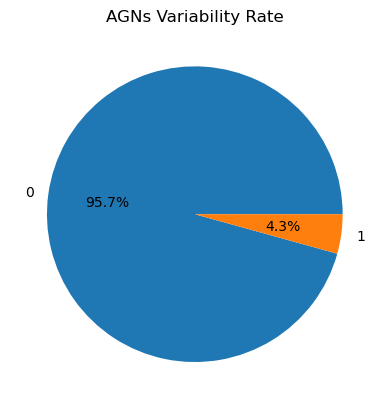

In [15]:
pie_x, pie_y = np.unique(features_df['Variability'], return_counts=True)
plt.pie(pie_y, labels=pie_x, autopct = '%1.1f%%') 
plt.title('AGNs Variability Rate')
plt.show()

# Pycaret AutoML

In [16]:
features_df.columns

Index(['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt', 'mag_w_e_mean',
       'mag_w_e_var', 'mag_w_e_skew', 'mag_w_e_kurt', 'Variability'],
      dtype='object')

In [17]:
# import pycaret for clasiification, the dataset is features_df and the target variable is Variability is very desbalanced
# we will use the SMOTE method to balance the dataset.
import pycaret
from pycaret.classification import *

# Setup the classification model
clf1 = setup(data=features_df[['mag_mean', 'mag_var', 'mag_skew', 'mag_kurt','Variability']], target='Variability',fix_imbalance=True)


,Description,Value
0,Session id,2211
1,Target,Variability
2,Target type,Binary
3,Original data shape,"(5225, 5)"
4,Transformed data shape,"(8568, 5)"
5,Transformed train set shape,"(7000, 5)"
6,Transformed test set shape,"(1568, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [28]:
# Compare the performance of different classification models
best_model = compare_models(include = ['lr', 'knn', 'dt', 'rf', 'lightgbm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9932,0.9925,0.9429,0.9054,0.9225,0.9189,0.9198,0.4740
rf,Random Forest Classifier,0.9929,0.9921,0.9300,0.9102,0.9183,0.9146,0.9156,0.0680
dt,Decision Tree Classifier,0.9910,0.9587,0.9233,0.8775,0.8985,0.8938,0.8948,0.0150
knn,K Neighbors Classifier,0.9106,0.8968,0.8029,0.3037,0.4376,0.4002,0.4581,0.0170
lr,Logistic Regression,0.8299,0.9200,0.8542,0.1833,0.3016,0.2485,0.3460,0.0170


In [29]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2211, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

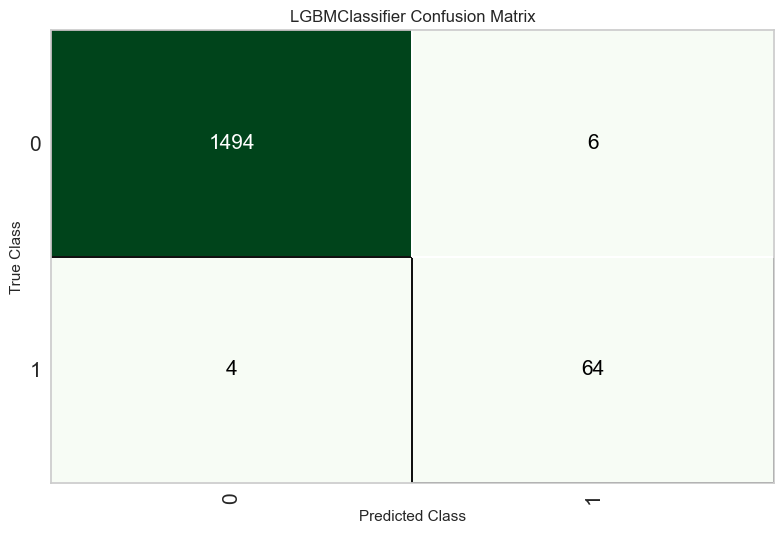

In [30]:
# plot confusion matrix
plot_model(best_model, plot = 'confusion_matrix')

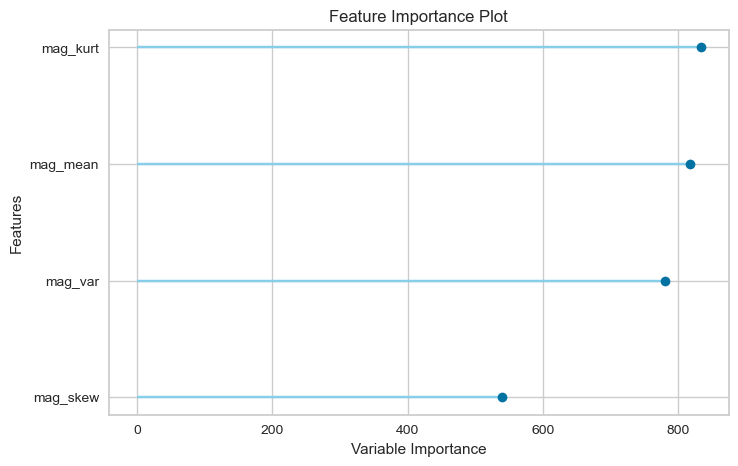

In [31]:
# plot feature importance
plot_model(best_model, plot = 'feature')

In [32]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [33]:
tuned_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9945,0.9998,1.0000,0.8889,0.9412,0.9383,0.9401
1,0.9945,0.9996,0.9375,0.9375,0.9375,0.9346,0.9346
2,0.9973,1.0000,1.0000,0.9412,0.9697,0.9683,0.9688
3,0.9945,0.9993,0.9375,0.9375,0.9375,0.9346,0.9346
4,0.9918,0.9950,0.8750,0.9333,0.9032,0.8990,0.8995
5,0.9891,0.9973,0.8750,0.8750,0.8750,0.8693,0.8693
6,0.9918,0.9984,0.9375,0.8824,0.9091,0.9048,0.9053
7,0.9890,1.0000,1.0000,0.7895,0.8824,0.8767,0.8834
8,0.9973,0.9998,1.0000,0.9375,0.9677,0.9663,0.9669


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
tuned_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2211, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [35]:
# predict on test set
holdout_pred = predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9936,0.9991,0.9412,0.9143,0.9275,0.9242,0.9243


In [36]:
# save the model in a variable to use for prediction
final_best_model = finalize_model(tuned_model)

In [37]:
# show predictions df
holdout_pred.head()

,mag_mean,mag_var,mag_skew,mag_kurt,Variability,prediction_label,prediction_score
70,0.000575,0.000024,1.145883,3.260194,0,0,1.0000
2990,0.091600,0.000040,0.356015,0.541956,0,0,1.0000
14,-0.010300,0.000017,0.062020,-0.824228,0,0,1.0000
3285,-0.015075,0.000032,-0.125191,-0.539186,0,0,1.0000
4115,-0.012250,0.000344,0.457123,-0.695567,0,0,0.9667


In [38]:
def calibration1(agn, star):

    rest = []
    
    for i in range(5):

        resta = abs (np.mean(star[i])-np.mean(agn))

        rest.append(resta)
    
        ind_min = np.argmin(rest)

        cal = agn - star[ind_min] #Calibrated magnitude
            
    return cal

In [39]:
def subsample_time_series(mag, t, subsample_size=30):
    """
    Subsample the time series data to simulate incomplete observations.

    :param t: AGN magnitudes
    :param subsample_size: The number of data points to subsample to.
    :return: Subsampled time series data mag.
    """
    # Ensure we always subsample the same way for reproducibility
    np.random.seed(0)
    
    # Choose random indices for subsampling
    subsample_indices = np.random.choice(len(t), size=subsample_size, replace=False)
    subsample_indices.sort()  # Sort the indices to maintain the time order
    
    return mag[subsample_indices], t[subsample_indices]

In [40]:
def extract_features_obs(mag,n, mag_w_err):
    """
    Extract features from the time series data for use in machine learning models.

    :param mag: Magnitude data array.
    :return: Extracted features.
    """
    features = {
        'mag_mean': np.mean(mag),
        'mag_var': np.var(mag),
        'mag_skew': skew(mag),
        'mag_kurt': kurtosis(mag),
    }

    err_features = {
        'err_mean_m': np.mean(mag)/n,
        'err_var_m': np.var(mag)/n,
        'err_skew_m': skew(mag)/n,
        'err_kurt_m': skew(mag)/n,
    }

    features_w_e = {
        'mag_w_e_mean': np.mean(mag),
        'mag_w_e_var': np.var(mag),
        'mag_w_e_skew': skew(mag),
        'mag_w_e_kurt': kurtosis(mag),
    }
    
    return features, features_w_e, err_features

In [41]:
#Create a dataframe for the observations an save it to a CSV file

def dataframe_obs(df): 
    
    D1 = df['D1'] #Diference between AGN and calibration star magnitudes
    err_D1 = df['eD1'] #error of the diference between AGN and calibration star magnitudes
    D2 = df['D2'] #Diference between AGN and control star magnitudes
    err_D2 = df['eD2'] #error of the diference between AGN and calibration star magnitudes

    #Calculates the Diference between D1 and D2
    mag = abs(D1-D2)
    err_obs = err_D1 + err_D2
    n = len(mag)

    rng = np.random.default_rng()
    t = rng.uniform(0, 2, 100)

    if t.any() <= 1:

        mag_w_err = mag + err_obs

    else:

        mag_w_err = mag - err_obs
        
    # Subsample the time series data to simulate incomplete observations
    #mag_subsampled = subsample_time_series(mag, t, subsample_size)        
    
    # Extract features from the time series data
    features_obs = extract_features_obs(mag, n, mag_w_err)[0]
    err_features_obs = extract_features_obs(mag, n, mag_w_err)[1]
    
    return features_obs, err_features_obs

In [42]:
dir

'obs/AGNs/'

In [43]:
#List all the AGNs, each one is a directory
names_agns = os.listdir(dir)
names_agns 

['agn_0847',
 'agn_1958',
 'agn_2126',
 'agn_1443',
 'agn_0208',
 'agn_1917',
 'agn_2310',
 'agn_0414',
 'agn_2149',
 'agn_1229',
 'agn_2005',
 'agn_1424',
 'agn_1256',
 'agn_0521',
 'agn_1510',
 'agn_1127',
 'agn_1116',
 'agn_2155']

In [44]:
len(names_agns)

18

In [45]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.
filelist = os.listdir(path)
df_obs = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        print(j)
        if j.endswith('.csv'):
            print(i+j)
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            print(file)
            long= len(file['D1'])
            print(long)

            data_features_obs = []

            features_obs = dataframe_obs(file)[0]
            
            # Store the features 
            data_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(data_features_obs)

            # Predict with the best model 
            predicted = predict_model(final_best_model, data=features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs = pd.DataFrame(df_obs)
df_obs['AGN_n_obs'] = names1
df_obs['Observations'] = observations

0847R-220414.csv
obs/AGNs/agn_0847/0847R-220414.csv
      dHJD     D1    eD1     D2    eD2
0   0.5011  0.431  0.004  0.796  0.004
1   0.5104  0.422  0.004  0.793  0.004
2   0.5203  0.435  0.004  0.797  0.004
3   0.5307  0.441  0.004  0.797  0.004
4   0.5410  0.436  0.004  0.793  0.004
5   0.5519  0.425  0.003  0.788  0.004
6   0.5629  0.428  0.004  0.781  0.004
7   0.5739  0.441  0.004  0.787  0.004
8   0.5852  0.429  0.004  0.777  0.004
9   0.5971  0.432  0.004  0.772  0.004
10  0.6093  0.428  0.004  0.776  0.004
11  0.6209  0.430  0.004  0.778  0.004
12


0847R-220414.csv :Classified    mag_mean   mag_var  mag_skew  mag_kurt  prediction_label  prediction_score
0   0.35475  0.000078    0.1852 -0.952915                 0               1.0 with 12 observations


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [35]:
features_df_var

,mag_w_e_mean,mag_w_e_var,mag_w_e_skew,mag_w_e_kurt
0,0.35475,0.000078,0.1852,-0.952915


In [35]:
path2

['obs/AGNs/agn_0847/',
 'obs/AGNs/agn_1958/',
 'obs/AGNs/agn_2126/',
 'obs/AGNs/agn_1443/',
 'obs/AGNs/agn_0208/',
 'obs/AGNs/agn_1917/',
 'obs/AGNs/agn_2310/',
 'obs/AGNs/agn_0414/',
 'obs/AGNs/agn_2149/',
 'obs/AGNs/agn_1229/',
 'obs/AGNs/agn_2005/',
 'obs/AGNs/agn_1424/',
 'obs/AGNs/agn_1256/',
 'obs/AGNs/agn_0521/',
 'obs/AGNs/agn_1510/',
 'obs/AGNs/agn_1127/',
 'obs/AGNs/agn_1116/',
 'obs/AGNs/agn_2155/']

In [54]:
#we go through all the subdirectories corresponding to each AGN and in each one all the files with different observations and we make a classification for each observation.

#path = '/home/anakin/Documents/Tesis/Codigo/AGNs/' #path to main directory
filelist = os.listdir(path)
df_obs_err = []
names1 = []
observations = []
k=0
#Make empty list to store all paths to subdirectories in.
path2 = []
for x in filelist:
    if x.startswith('agn'):
        path2.append(path + x+ '/')

for i in path2:
    filelist2 = os.listdir(i)
    c=0
    p=0
    for j in filelist2:
        if j.endswith('.csv'):
            file = pd.read_csv(i+j, dtype=np.float64, na_values='INDEF')
            long= len(file['D1'])

            err_features_obs = []

            features_obs = dataframe_obs(file)[1]
            
            # Store the features 
            err_features_obs.append(features_obs)    
                
            # Convert lists to a DataFrame
            features_df_var = pd.DataFrame(err_features_obs)

            # Predict with the model
            predicted = rf_classifier0.predict(features_df_var)
    
            print(j, ':Classified', predicted, 'with', long, 'observations')

            c+=1
            if predicted == 1:
                
                df_obs_err.append(features_obs)
                names1.append(j)
                observations.append(long)

                p+=1
                
    prob = p/c*100

    print('-------------------------------------------------',names_agns[k], 'is variable whit a probability of:', prob, '%')
    k+=1

# Convert lists to a DataFrame
df_obs_err = pd.DataFrame(df_obs_err)
df_obs_err['AGN_n_obs'] = names1
df_obs_err['Observations'] = observations

NameError: name 'rf_classifier0' is not defined